In [5]:
#import and load data

# Imports 
import os, re, random, math
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
random.seed(42); np.random.seed(42)

# === Load Data ===
# Adjust paths if needed (use "../01_data/..." or "data/...") 
with open("../01_data/corpus.txt", "r", encoding="utf-8") as f:
    corpus_words = [w.strip().lower() for w in f if w.strip()]

with open("../01_data/test.txt", "r", encoding="utf-8") as f:
    test_words = [w.strip().lower() for w in f if w.strip()]

alphabet = list("abcdefghijklmnopqrstuvwxyz")

print("Corpus size:", len(corpus_words))
print("Test size:", len(test_words))



Corpus size: 50000
Test size: 2000


In [6]:
# Utilities for Candidate Filtering

def pattern_to_regex(masked, excluded):
    """
    masked: like '__a_e'
    excluded: letters known NOT in the word (wrong guesses)
    Build a regex that:
      - fixes revealed letters
      - prohibits excluded letters in blank positions
    """
    parts = []
    excluded_class = f"[^{''.join(sorted(excluded))}]" if excluded else "."
    for ch in masked:
        if ch == "_":
            parts.append(excluded_class)
        else:
            parts.append(ch)
    rx = "^" + "".join(parts) + "$"
    return re.compile(rx)

def candidate_words(masked, guessed, word_list):
    """Return words compatible with masked pattern and guessed info."""
    excluded = set(guessed) - set(masked.replace("_",""))
    rx = pattern_to_regex(masked, excluded)
    L = len(masked)
    return [w for w in word_list if len(w)==L and rx.match(w)]

def letter_freq_from_candidates(cands, guessed):
    """Frequency of letters among remaining candidates, excluding guessed."""
    counts = Counter()
    remaining = set(alphabet) - set(guessed)
    for w in cands:
        for ch in set(w):  # set() to reduce bias by duplicates
            if ch in remaining:
                counts[ch] += 1
    if not counts:
        return {c: 1e-9 for c in remaining}  # avoid zeros
    total = sum(counts.values())
    return {c: counts.get(c,0)/total for c in alphabet}


In [7]:
#HMM hangman model (length + position aware)

class HMMHangman:
    """
    Simple, robust HMM-style oracle:
      - Global letter prior P(letter)
      - Per-length letter prior P(letter | length=L)
      - Per-position letter prior P(letter | length=L, position=i)
    We mix these with tunable weights to get a usable letter distribution.
    """
    def __init__(self, alpha_smooth=1.0, w_global=0.2, w_len=0.3, w_pos=0.5):
        self.alpha = alpha_smooth
        self.wg, self.wl, self.wp = w_global, w_len, w_pos
        self.global_counts = Counter()
        self.len_counts = defaultdict(Counter)           # len -> counts(letter)
        self.pos_counts = defaultdict(lambda: defaultdict(Counter))  # len -> pos -> counts(letter)
        self.trained = False

    def train(self, words):
        for w in words:
            L = len(w)
            for i,ch in enumerate(w):
                if ch in alphabet:
                    self.global_counts[ch] += 1
                    self.len_counts[L][ch] += 1
                    self.pos_counts[L][i][ch] += 1
        # Precompute smoothed distributions
        self.P_global = self._normalize(self.global_counts, self.alpha)
        self.P_len = {L: self._normalize(cnts, self.alpha) for L,cnts in self.len_counts.items()}
        self.P_pos = {
            L: {i: self._normalize(cnts, self.alpha) for i,cnts in pos.items()}
            for L,pos in self.pos_counts.items()
        }
        self.trained = True

    def _normalize(self, counter, alpha):
        total = sum(counter[c] + alpha for c in alphabet)
        return {c: (counter[c] + alpha) / total for c in alphabet}

    def predict_letter_probs(self, masked_word, guessed):
        """
        Return a distribution over letters not yet guessed.
        Mixture of global, length and per-position information.
        """
        assert self.trained, "Train HMM first"
        L = len(masked_word)
        remaining = set(alphabet) - set(guessed)
        # global
        P_g = self.P_global
        # length
        P_l = self.P_len.get(L, P_g)
        # positions
        pos_list = []
        for i,ch in enumerate(masked_word):
            if ch == "_":
                pos_list.append(self.P_pos.get(L, {}).get(i, P_l))
        # mixture
        pos_mix = {c: 0.0 for c in alphabet}
        if pos_list:
            # average positional distributions
            for dist in pos_list:
                for c in alphabet:
                    pos_mix[c] += dist.get(c, 0.0)
            for c in alphabet:
                pos_mix[c] /= len(pos_list)
        else:
            pos_mix = P_l

        raw = {c: self.wg*P_g.get(c,0)+ self.wl*P_l.get(c,0)+ self.wp*pos_mix.get(c,0) for c in alphabet}
        # remove guessed + renormalize
        filtered = {c: (raw[c] if c in remaining else 0.0) for c in alphabet}
        s = sum(filtered.values())
        if s == 0:
            # uniform fallback among remaining
            u = 1.0 / max(1,len(remaining))
            return {c: (u if c in remaining else 0.0) for c in alphabet}
        return {c: filtered[c]/s for c in alphabet}




In [8]:
# Hangman Environment (with reveal count & step penalty)


class HangmanEnv:
    def __init__(self, words, max_wrong=6, step_penalty=0.05):
        self.words = words
        self.max_wrong = max_wrong
        self.step_penalty = step_penalty
        self.reset()

    def reset(self, random_word=True):
        if random_word:
            self.word = random.choice(self.words)
        self.guessed = set()
        self.wrong = 0
        self.prev_mask = self.mask()
        return self._state()

    def mask(self):
        return ''.join(c if c in self.guessed else "_" for c in self.word)

    def _state(self):
        return (self.mask(), self.wrong, frozenset(self.guessed))

    def step(self, action):
        done = False
        reward = -self.step_penalty  # discourage long games

        if action in self.guessed:
            reward -= 3  # stronger repeat penalty
        else:
            self.guessed.add(action)
            if action in self.word:
                # reward by number of newly revealed positions
                new_mask = self.mask()
                reveals = sum(1 for a,b in zip(self.prev_mask,new_mask) if a!=b)
                reward += 2 + 0.5*reveals
                self.prev_mask = new_mask
            else:
                self.wrong += 1
                reward -= 1

        cur_mask = self.mask()
        if cur_mask == self.word:
            reward += 10
            done = True
        elif self.wrong >= self.max_wrong:
            reward -= 5
            done = True

        return self._state(), reward, done


In [9]:
#  train HMM

# Train HMM
# Train HMM model
hmm = HMMHangman(alpha_smooth=1.0, w_global=0.2, w_len=0.3, w_pos=0.5)
hmm.train(corpus_words)
print("✅ HMM trained successfully")

# Test HMM output for a sample masked word
masked = "__a_e"
guessed = {'a', 'e'}
probs = hmm.predict_letter_probs(masked, guessed)

# print top 10 most likely letters
print("HMM prediction for masked word:", masked)
for letter, p in sorted(probs.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{letter}: {p:.4f}")






✅ HMM trained successfully
HMM prediction for masked word: __a_e
o: 0.0892
i: 0.0874
r: 0.0787
s: 0.0741
l: 0.0700
t: 0.0681
u: 0.0654
n: 0.0644
c: 0.0481
h: 0.0413


In [ ]:
# RL Q-learning Agent (with action filtering & smart fallback)

class QAgent:
    def __init__(self, alpha=0.15, gamma=0.93, eps=1.0):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.actions = alphabet

    def _key(self, state, probs):
        mask, wrong, guessed = state
        guessed = ''.join(sorted(guessed))
        # coarse quantization of probs for key (reduces Q-table explosion)
        p = tuple(int(probs[c]*20) for c in self.actions)  # 0..20 buckets
        return (mask, wrong, guessed, p)

    def _best_action_from_Q(self, key, allowed):
        self.Q.setdefault(key, np.zeros(len(self.actions)))
        idxs = [self.actions.index(a) for a in allowed]
        best_idx = idxs[np.argmax([self.Q[key][i] for i in idxs])]
        return self.actions[best_idx]

    def choose(self, state, probs, allowed, fallback_scores=None):
        # ε-greedy among allowed
        if random.random() < self.eps:
            return random.choice(list(allowed))
        key = self._key(state, probs)
        self.Q.setdefault(key, np.zeros(len(self.actions)))
        # pick best from Q over allowed
        if allowed:
            a_q = self._best_action_from_Q(key, allowed)
        else:
            a_q = random.choice(self.actions)

        # smart fallback: if Q-values are flat (early training), use heuristic scores
        if fallback_scores is not None:
            # mix: 70% fallback, 30% Q preference
            mix = {a: 0.7*fallback_scores.get(a,0) + 0.3*probs.get(a,0) for a in allowed}
            if mix and (max(mix.values()) > 0):
                return max(mix, key=mix.get)
        return a_q
    

    def learn(self, state, action, reward, next_state, probs, next_probs, allowed_next):
        key = self._key(state, probs)
        next_key = self._key(next_state, next_probs)
        self.Q.setdefault(key, np.zeros(len(self.actions)))
        self.Q.setdefault(next_key, np.zeros(len(self.actions)))
        a = self.actions.index(action)
        # target = r + γ * max_a' Q(s', a') over allowed_next
        if allowed_next:
            idxs = [self.actions.index(a2) for a2 in allowed_next]
            next_max = max(self.Q[next_key][i] for i in idxs)
        else:
            next_max = 0.0
        self.Q[key][a] += self.alpha * (reward + self.gamma*next_max - self.Q[key][a])



In [11]:
# Train RL Agent with(e-Decay & logging)
# Train RL
env = HangmanEnv(corpus_words, max_wrong=6, step_penalty=0.05)
agent = QAgent(alpha=0.15, gamma=0.93, eps=1.0)

EPISODES = 25000  # you can keep 20k–50k; 25k is decent
rewards_per_episode = []

for ep in tqdm(range(EPISODES)):
    state = env.reset()
    total = 0.0
    done = False

    while not done:
        masked, wrong, guessed = state
        probs = hmm.predict_letter_probs(masked, guessed)
        # allowed = not guessed
        allowed = set(alphabet) - set(guessed)
        # candidate fallback advisor
        cands = candidate_words(masked, guessed, corpus_words)
        advisor = letter_freq_from_candidates(cands, guessed)

        action = agent.choose(state, probs, allowed, fallback_scores=advisor)
        next_state, reward, done = env.step(action)
        total += reward

        next_masked, _, next_guessed = next_state
        next_probs = hmm.predict_letter_probs(next_masked, next_guessed)
        allowed_next = set(alphabet) - set(next_guessed)

        agent.learn(state, action, reward, next_state, probs, next_probs, allowed_next)
        state = next_state

    rewards_per_episode.append(total)
    # ε-decay faster early, then slow tail
    agent.eps = max(0.02, agent.eps * (0.997 if ep < 8000 else 0.9992))

print("✅ Training done | Final epsilon =", round(agent.eps, 4))
print("Q-table size:", len(agent.Q))


100%|██████████| 25000/25000 [14:56<00:00, 27.88it/s] 

✅ Training done | Final epsilon = 0.02
Q-table size: 139280


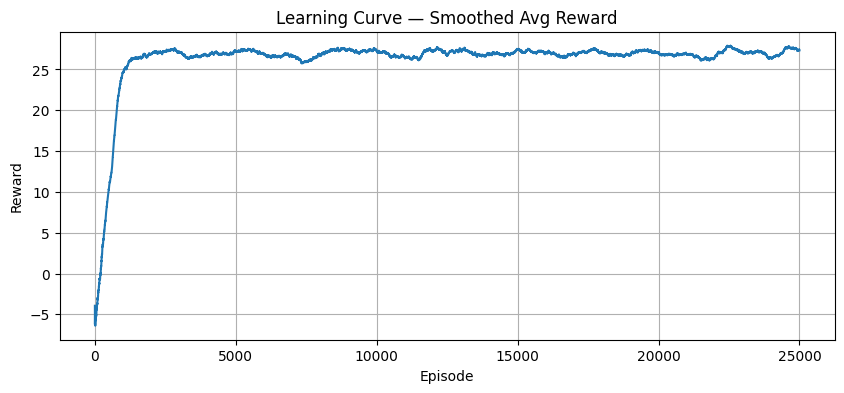

In [12]:
# plot Learning Curve

# Smoothed average over sliding window
window = 600
smooth = [np.mean(rewards_per_episode[max(0,i-window):i+1]) for i in range(len(rewards_per_episode))]

plt.figure(figsize=(10,4))
plt.plot(smooth)
plt.title("Learning Curve — Smoothed Avg Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()
 


In [ ]:
#  Evaluate on test data
wins = wrong_total = repeat_total = 0
env_test = HangmanEnv(test_words, max_wrong=6, step_penalty=0.0)
agent.eps = 0  # greedy at test time

for word in tqdm(test_words):
    env_test.word = word
    state = env_test.reset(random_word=False)

    guessed_letters = set()
    masked, wrong, guessed = state

    hmm_cache = {}
    steps = 0
    MAX_STEPS = 50

    while steps < MAX_STEPS:
        steps += 1
        key = (masked, tuple(sorted(guessed_letters)))
        if key not in hmm_cache:
            # compute probs + advisor
            probs = hmm.predict_letter_probs(masked, guessed_letters)
            cands = candidate_words(masked, guessed_letters, corpus_words)
            advisor = letter_freq_from_candidates(cands, guessed_letters)
            hmm_cache[key] = (probs, advisor)
        else:
            probs, advisor = hmm_cache[key]

        allowed = (set(alphabet) - set(guessed_letters))
        if not allowed:
            break

        action = agent.choose(state, probs, allowed, fallback_scores=advisor)

        if action in guessed_letters:
            repeat_total += 1
        guessed_letters.add(action)

        next_state, _, done = env_test.step(action)
        masked, wrong, guessed = next_state
        state = next_state
        if done:
            break

    if masked == env_test.word:
        wins += 1
    wrong_total += wrong

success_rate = wins / len(test_words)
score = (wins * 2000) - (wrong_total * 5) - (repeat_total * 2)

print(f"Success Rate: {success_rate:.3f}")
print("Number of wins:", success_rate*2000)
print("Number of losses:",2000-(success_rate*2000))
print(" Wrong guesses:", wrong_total)
print(" Repeated guesses:", repeat_total)
print(" Final Score:", score)





100%|██████████| 2000/2000 [01:22<00:00, 24.19it/s]

Success Rate: 0.201
Number of wins: 401.0
Number of losses: 1599.0
 Wrong guesses: 11113
 Repeated guesses: 0
 Final Score: 746435


In [17]:

pd.DataFrame({
    "Metric": ["Success Rate", "Number of wins" , "Number of losses", "Wrong Guesses", "Repeated Guesses", "Final Score"],
    "Value": [f"{success_rate:.2f}", success_rate*2000, 2000-(success_rate*2000), wrong_total, repeat_total, score]
})

,Metric,Value
0,Success Rate,0.20
1,Number of wins,401.0
2,Number of losses,1599.0
3,Wrong Guesses,11113
4,Repeated Guesses,0
5,Final Score,746435
